### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Final Exam [60 points total]
### Available: Saturday, May 8th at 11am CDT
### Due: Monday, May 10th at 11am CDT
---

## Problem 1 [30 points total]

One of the most important revelations in modern cosmology was the accelerated expansion of the Universe, interpreted as being caused by a non-zero Cosmological Constant. In this question you will use a simulated sample of Type Ia supernovae to infer the composition of the Universe. 

1. Load in `astr8070_final_cosmodata.npy`, which can be found in the Github repo under `coursework/final/final_data`. The first column is the SN redshift, the second is the distance modulus, and the third is the Gaussian uncertainty on this distance modulus. Make a labeled scatter plot of the data. [2 points]


2. Plot a line on top of this showing the relationship between the distance modulus and the redshift for the current concordance cosmology. You will need to look up the definition of the distance modulus, look up current reasonable cosmological parameters (cite your source), and plot the relationship. *Hint: check astropy.* [3 points]


3. Create a log-likelihood function that reads in the data and accepts values for the Hubble constant, $H_0$, and the fractional energy density in matter, $\Omega_M$. Assume a flat cosmological geometry, such that $\Omega_M + \Omega_\Lambda=1$. Your function should take $H_0$ and $\Omega_M$, and create a model for the distance moduli values at the redshifts of the samples, then compute the log-likelihood for the data. Print out the log-likelihood value at the cosmological parameter values that you used in (2). For maximum points, make sure your log-likelihood function is vectorized over the data samples. [6 points]


4. Perform an MCMC with appropriate diagnostic checks (either manually yourself, or fine if performed by the sampler you employ) over the $\{H_0, \Omega_M\}$ parameter space. Assume priors of $H_0 \in U[50,100]$ km.s$^{-1}$.Mpc$^{-1}$, and $\Omega_M \in U[0,1]$. Make a labeled corner plot showing the $1$D and $2$D marginalized posterior probability distribution of these parameters. State the median value of the $1$D marginal posteriors for each, along with the values enclosing the $68\%$ credible region. [8 points]


5. Draw $100$ random samples from your posterior chain and plot the corresponding band of solutions that are consistent with the data on the distance-modulus--vs--redshift plot along with the original data. [4 points]


6. Now, using an appropriate technique, find the Bayesian log-evidence of your $\{H_0,\Omega_M\}$ model above. Also find the log-evidence of a model with $\Omega_M=1$ such that $H_0$ is the only varied parameter. What is the Bayes factor for the presence of a Cosmological Constant given these data? [7 points] 

In [153]:
import numpy as np
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import emcee
import dynesty
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from astropy.coordinates import Distance
from astropy.cosmology import FlatLambdaCDM
import corner

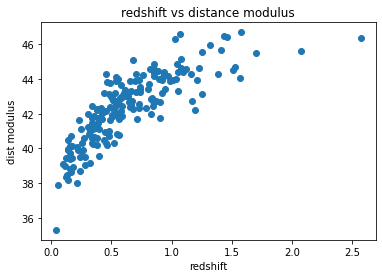

200


In [20]:
#1
data1 = np.load('../../final/final_data/astr8070_final_cosmodata.npy')
plt.scatter(data1[:,0],data1[:,1])
plt.xlabel('redshift')
plt.ylabel('dist modulus')
plt.title('redshift vs distance modulus')
plt.show()
print(len(data))

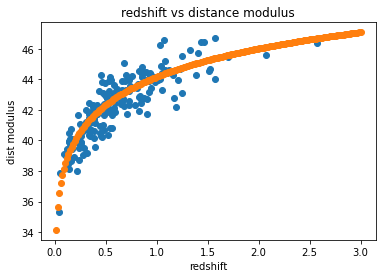

In [21]:
#2
#I consulted the astropy documentation and I'm using their values for the current cosmology and their distance moduli
#(https://docs.astropy.org/en/stable/api/astropy.coordinates.Distance.html)
#WMAP 7: H0= 70.4, Om= .272
z= np.linspace(0,3,200)
zdist= Distance(z=z)
zmod= zdist.distmod

plt.scatter(data1[:,0],data1[:,1])
plt.scatter(z,zmod)
plt.xlabel('redshift')
plt.ylabel('dist modulus')
plt.title('redshift vs distance modulus')
plt.show()

In [39]:
#3
#theta = [H0,Om]
ydata= data1[:,1]
z= data1[:,0]
sigma= data1[:,2]

def modulus(theta,z):
    cosmo= FlatLambdaCDM(H0=theta[0],Om0=np.abs(theta[1]))
    zdist= Distance(cosmology=cosmo,z=z)
    zmod= np.asarray(zdist.distmod)
    return zmod

def likely(theta,z,ydata,sigma):
    mu= modulus(theta,z)
    L= np.prod((1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((ydata-mu)**2)/sigma**2))
    return L

def posterior(theta,z,ydata,sigma):
    prior=1 #placeholder, I'll put the real ones in in the next cell
    pdf= likely(theta,z,ydata,sigma)*prior
    return pdf    

def loglikely(theta,z,ydata,sigma):
    logL= np.log(posterior(theta,z,ydata,sigma))
    return logL

print(loglikely([70.4,.272],z,ydata,sigma))

-266.77164156227997


In [40]:
#4
def posterior(theta,z,ydata,sigma):
    priors=stats.uniform(50,50).pdf(theta[0])*stats.uniform(0,1).pdf(theta[1])
    pdf= likely(theta,z,ydata,sigma)*priors
    return pdf    
def loglikely(theta,z,ydata,sigma):
    logL= np.log(posterior(theta,z,ydata,sigma))
    return logL

ndim = 2  #parameters
nwalkers = 10  # walkers
nstep = 5000  # steps per walker

# initializing near the a priori parameters
starting_guesses= np.empty([10,2])
starting_guesses[:,0]= np.random.random_sample(10)+70
starting_guesses[:,1]= .1*np.random.random_sample(10)+.4
sampler = emcee.EnsembleSampler(nwalkers,ndim,loglikely,args=[z,ydata,sigma])
sampler.run_mcmc(starting_guesses, nstep)



<ipython-input-40-14099cd5d530>:7: RuntimeWarning: divide by zero encountered in log
  logL= np.log(posterior(theta,z,ydata,sigma))


State([[71.74744092  0.31913911]
 [71.88463132  0.28228702]
 [70.67388282  0.34424131]
 [69.29544157  0.3163471 ]
 [62.24031618  0.86485265]
 [78.9559097   0.14337006]
 [73.1623554   0.32693095]
 [75.40042552  0.24994837]
 [77.71675961  0.13636615]
 [71.74059819  0.31465086]], log_prob=[-270.24674543 -270.18840891 -270.30100067 -270.72285367 -273.09203995
 -270.85689923 -270.65137535 -270.55536618 -270.56650839 -270.22839348], blobs=None, random_state=('MT19937', array([1389439334,  974725888, 1041246175, 2463583415,  495851730,
       1697264740, 4199761736, 2662477149, 1405174541,  323862824,
        584677465,  821984041, 3254914210, 2091378162, 1046687005,
       2438700689,  744707789, 3201301764, 3641666066, 1417109431,
       3624115742, 4127947535, 3689553363, 3814011188,  620393979,
        977011136,  463802246, 1750012010, 1516895925, 3887604945,
        326805577, 2900058314, 4184098805, 2256535376, 3949074907,
       4037423627, 3574558733, 1052116761,  307693193, 36771458

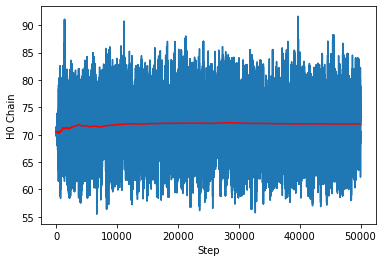

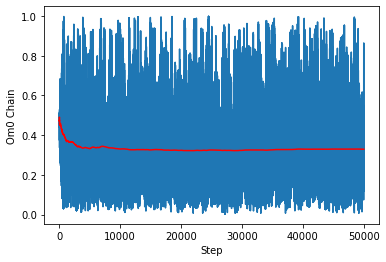

In [46]:
emcee_trace= sampler.get_chain()
emcee_trace_H0  = sampler.get_chain()[:,:,0].reshape(-1,1)
emcee_trace_Om0  = sampler.get_chain()[:,:,1].reshape(-1,1)

plt.plot(np.linspace(1,len(emcee_trace_H0),len(emcee_trace_H0)),emcee_trace_H0)
meanchain = [np.mean(emcee_trace_H0[:int(N)]) for N in np.linspace(1,len(emcee_trace_H0),len(emcee_trace_H0))]
plt.plot(np.linspace(1,len(emcee_trace_H0),len(emcee_trace_H0)), meanchain, c='red', label='chain mean')
plt.xlabel('Step')
plt.ylabel('H0 Chain')
plt.show()

plt.plot(np.linspace(1,len(emcee_trace_Om0),len(emcee_trace_Om0)),emcee_trace_Om0)
meanchain = [np.mean(emcee_trace_Om0[:int(N)]) for N in np.linspace(1,len(emcee_trace_Om0),len(emcee_trace_Om0))]
plt.plot(np.linspace(1,len(emcee_trace_Om0),len(emcee_trace_Om0)), meanchain, c='red', label='chain mean')
plt.xlabel('Step')
plt.ylabel('Om0 Chain')
plt.show()
#looking at this I'll go ahead and remove 1500 steps of burn in

autocorrelation times = [36.09876725 33.7312607 ]
acceptance fractions = [0.7016 0.6968 0.698  0.6904 0.7058 0.7    0.7154 0.717  0.6986 0.718 ]


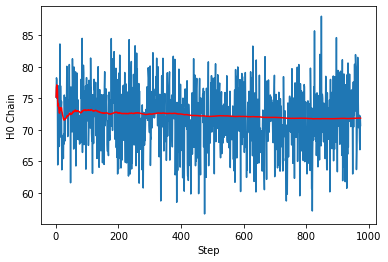

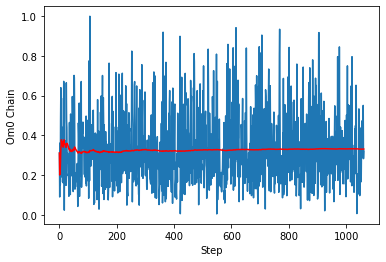

In [47]:
autoc = sampler.get_autocorr_time(discard=1500)
print('autocorrelation times = ' +str(autoc))
acc= sampler.acceptance_fraction
print('acceptance fractions = '+str(acc))

#burn in
emcee_trace= emcee_trace[1500:,:,:]
emcee_trace_H0= emcee_trace_H0[15000:]
emcee_trace_Om0= emcee_trace_Om0[15000:]

#thinning
emcee_trace_H0= emcee_trace_H0[::int(autoc[0])]
emcee_trace_Om0= emcee_trace_Om0[::int(autoc[1])]

#replotting
plt.plot(np.linspace(1,len(emcee_trace_H0),len(emcee_trace_H0)),emcee_trace_H0)
meanchain = [np.mean(emcee_trace_H0[:int(N)]) for N in np.linspace(1,len(emcee_trace_H0),len(emcee_trace_H0))]
plt.plot(np.linspace(1,len(emcee_trace_H0),len(emcee_trace_H0)), meanchain, c='red', label='chain mean')
plt.xlabel('Step')
plt.ylabel('H0 Chain')
plt.show()

plt.plot(np.linspace(1,len(emcee_trace_Om0),len(emcee_trace_Om0)),emcee_trace_Om0)
meanchain = [np.mean(emcee_trace_Om0[:int(N)]) for N in np.linspace(1,len(emcee_trace_Om0),len(emcee_trace_Om0))]
plt.plot(np.linspace(1,len(emcee_trace_Om0),len(emcee_trace_Om0)), meanchain, c='red', label='chain mean')
plt.xlabel('Step')
plt.ylabel('Om0 Chain')
plt.show()

(35000, 2)
H0 median = 72.00934842523856
Om0 median = 0.2996919497018041
H0 68% values = [66.89071143 77.11971724]
Om0 68% values = [0.15922426 0.50425718]


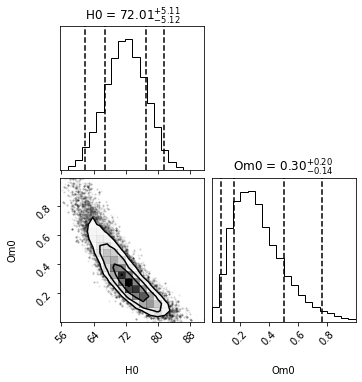

In [51]:
#corner
samples= emcee_trace.reshape(-1,2)
print(samples.shape)
corner.corner(samples,labels=['H0','Om0'],quantiles=[0.025,0.16,0.84,0.975],show_titles=True)
print('H0 median = '+str(np.median(samples[:,0])))
print('Om0 median = '+str(np.median(samples[:,1])))
print('H0 68% values = '+str(np.percentile(samples[:,0],[16,84])))
print('Om0 68% values = '+str(np.percentile(samples[:,1],[16,84])))

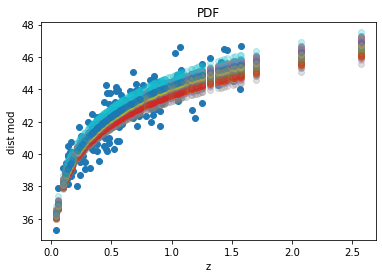

In [53]:
#5
#borrowing my own routine for generating realizations from MCMC that I used in hw5, modifying for this
params= np.empty([2,100])
H0random= np.random.choice(np.squeeze(emcee_trace_H0),100)
Om0random= np.random.choice(np.squeeze(emcee_trace_Om0),100)
params[0,:]= H0random
params[1,:]= Om0random

#generating 100 realizations and overplotting the truth
yvals= np.empty([100,len(z)])
plt.scatter(data1[:,0],data1[:,1])
plt.xlabel('z')
plt.ylabel('dist mod')
plt.title('PDF')
for i in range(100):
    yvals[i,:]= modulus(params[:,i],z)
    plt.scatter(data[:,0],yvals[i,:],alpha=.25)
    
plt.show()

In [61]:
#6
def logLdynesty(theta,z,ydata,sigma):
    logL= np.log(likely(theta,z,ydata,sigma))
    return logL
logl_args=[z,ydata,sigma]

def ptflambda(u):
    x= np.asarray(u)
    x[0]= 50*u[0]+50
    x[1]= u[1]
    return x
sampler = dynesty.NestedSampler(logLdynesty,ptflambda,ndim=2,logl_args=logl_args)
sampler.run_nested()
sresults = sampler.results

1966it [00:09, 207.23it/s, +500 | bound: 1 | nc: 1 | ncall: 18121 | eff(%): 13.609 | loglstar:   -inf < -266.228 <    inf | logz: -269.318 +/-  0.091 | dlogz:  0.001 >  0.509]


In [62]:
def modulusnolambda(theta,z):
    cosmo= FlatLambdaCDM(H0=theta[0],Om0=1)
    zdist= Distance(cosmology=cosmo,z=z)
    zmod= np.asarray(zdist.distmod)
    return zmod

def likelynolambda(theta,z,ydata,sigma):
    mu= modulusnolambda(theta,z)
    L= np.prod((1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((ydata-mu)**2)/sigma**2))
    return L   

def loglikelynolambda(theta,z,ydata,sigma):
    logL= np.log(likelynolambda(theta,z,ydata,sigma))
    return logL

def ptfnolambda(u):
    x= 50*u+50
    return x

samplernolambda = dynesty.NestedSampler(loglikelynolambda,ptfnolambda,ndim=1,logl_args=logl_args)
samplernolambda.run_nested()
sresultsnolambda = samplernolambda.results

1621it [00:05, 278.70it/s, +500 | bound: 0 | nc: 1 | ncall: 12924 | eff(%): 16.411 | loglstar:   -inf < -269.786 <    inf | logz: -272.121 +/-  0.055 | dlogz:  0.001 >  0.509]


In [64]:
from dynesty import plotting as dyplot
sresults.summary()
sresultsnolambda.summary()

print('Bayes Factor LCDM/No L ='+str(10**-269.318/10**-272.121))
#The LCDM model is much preferred.

Summary
nlive: 500
niter: 1966
ncall: 18121
eff(%): 13.609
logz: -269.318 +/-  0.091
Summary
nlive: 500
niter: 1621
ncall: 12924
eff(%): 16.411
logz: -272.121 +/-  0.055
Bayes Factor LCDM/No L =635.3309318517396


## Problem 2 [30 points total]

There are several empirical scaling relationships between the masses of black holes in galaxy centers and the properties of their hosts. In this problem you will use real data from the "MASSIVE" Galaxy Survey. This data updates that used in [McConnell & Ma (2013)](https://ui.adsabs.harvard.edu/abs/2013ApJ...764..184M/abstract), which presented a systematic investigation of scaling relations with different catalog subsets.

1. Download this dataset: http://blackhole.berkeley.edu/wp-content/uploads/2016/09/current_ascii.txt. Skip the appropriate header rows and read this into a `pandas` dataframe. Use the meta-data in the header rows to create appropriate column names for your dataframe. Make sure that your data file is properly formatted with tab-spaced columns so that it is readable without errors. [3 points]


2. Create a data matrix out of the base-10 log values of: the galaxy distance, the velocity dispersion $\sigma$, and the black hole mass. Create a target vector that has $1$ for early-type galaxies (morphology has `E` or `S0` in the value) and $0$ for late-type galaxies. Print out the number of early-type and late-type galaxies that are in your target vector, as well as the total number of galaxies. [3 points]


3. Perform a 50-50 train-test split on the data matrix and target vector, using `random_state=0` for reproducibility. Train the following classifiers, overplotting ROC curves for all:
    - Gaussian Naive Bayes
    - LDA
    - QDA
    - $K$-nearest neighbors (with $K=10$)
    - Gaussian mixture model (with $2$ components)
    - Decision Tree (with `entropy` criterion, and tree depth $=2$)
 [5 points]
    

4. What minimum tree depth do you need to achieve essentially perfect classification accuracy with the Decision Tree? Confirm this by making a two-panel figure with scatter plots of the log10-distance and log10-sigma from the test data, color-coded by the test label (left panel) and predicted label (right panel).  [3 points]


5. The following regression tasks should all produce best-fit regression coefficients and a plot. State how many galaxies are being fit in each scenario.
    - Use the $68\%$ low and high black-hole mass values to deduce the uncertainty on each $(M_\mathrm{BH}/M_\odot)$. Convert this into an uncertainty on $\log_{10}(M_\mathrm{BH}/M_\odot)$. Ignoring the uncertainties on $\sigma$, perform linear regression of the form
$$ \log_{10}(M_\mathrm{BH}/M_\odot) = \alpha + \beta\log_{10}(\sigma \,/\, 200\,\mathrm{km.s}^{-1})$$
and state the best-fit regression coefficients $\{\alpha,\beta\}$. Plot the best-fit line on a scatter plot with the data. 
    - Repeat the previous bullet to fit and plot the relation $$ \log_{10}(M_\mathrm{BH}/M_\odot) = \alpha + \beta\log_{10}(L_V \,/\, 10^{11}L_\odot)$$ for the sub-sample of galaxies with $V$-band luminosity data (ignoring the $L_V$ uncertainties).
    - Repeat to fit and plot the relation $$ \log_{10}(M_\mathrm{BH}/M_\odot) = \alpha + \beta\log_{10}(M_\mathrm{bulge} \,/\, 10^{11}M_\odot)$$ for the sub-sample of galaxies with bulge mass measurements (ignoring the $M_\mathrm{bulge}$ uncertainties).
 [7 points]
 
 
6. Perform polynomial regression of the form
$$ \log_{10}(M_\mathrm{BH}/M_\odot) = \alpha + \sum_{p=1}^{N_p}\beta_p[\log_{10}(\sigma \,/\, 200\,\mathrm{km.s}^{-1})]^p.$$
For $N_p$ in the range $0$ to $5$, fit the polynomial relationship, print the regression coefficients, and compute the BIC value. Make a labeled plot of the BIC versus the polynomial degree. Is a quadratic or higher polynomial relationship between $\log_{10}(M_\mathrm{BH}/M_\odot)$ and $\log_{10}(\sigma \,/\, 200\,\mathrm{km.s}^{-1})$ favored? [5 points]


7. Perform linear regression ($N_p=1$) on the dataset on sub-samples of early-type and late-type galaxies. Print the best-fit regression coefficients from each of these sub-sets. Make a scatter plot that includes the original data color coded by early/late type, the fit to all of the data, and the fits from the early/late-type sub-samples. The plot should have appropriate labels and a legend. [4 points]

In [88]:
#1
data2= pd.read_table('./MASSIVE.txt',skiprows=25,header=None,delim_whitespace=True)
col= ['Galaxy','Distance (Mpc)','MBH (Msun)','MBH lower (68%)','MBH upper (68%)','method','sigma (km/s)',
      'sigma lower (68%)','sigma upper (68%)','log(LV/Lsun)','error in log(LV/Lsun)','log(L_3.6/Lsun) -- Spitzer 3.6 um, from Sani et al. 2011'
      ,'error in log(L_3.6/Lsun)','Mbulge/Msun','radius of influence (arcsec)','Morphology -- (E)lliptical, S0, (S)piral',
      'Profile -- (P)ower-law, (I)ntermediate, (C)ore, (U)ndetermined','Reff (V-band, arcsec)','Reff (i-band, arcsec) -- SDSS DR7, from Beifiori et al. 2012',
      'Reff (3.6 um, arcsec) -- from Sani et al. 2011]']

data2.columns=col
data2.head()



,Galaxy,Distance (Mpc),MBH (Msun),MBH lower (68%),MBH upper (68%),method,sigma (km/s),sigma lower (68%),sigma upper (68%),log(LV/Lsun),error in log(LV/Lsun),"log(L_3.6/Lsun) -- Spitzer 3.6 um, from Sani et al. 2011",error in log(L_3.6/Lsun),Mbulge/Msun,radius of influence (arcsec),"Morphology -- (E)lliptical, S0, (S)piral","Profile -- (P)ower-law, (I)ntermediate, (C)ore, (U)ndetermined","Reff (V-band, arcsec)","Reff (i-band, arcsec) -- SDSS DR7, from Beifiori et al. 2012","Reff (3.6 um, arcsec) -- from Sani et al. 2011]"
0,MW,0.008,4.100000e+06,3.500000e+06,4.700000e+06,star,103.0,83.0,123.0,0.00,0.00,0.00,0.00,0.000000e+00,43.00,S,NaN,0.0,0.00,0.00
1,A1836,157.500,3.900000e+09,3.300000e+09,4.300000e+09,gas,288.0,274.0,302.0,11.26,0.06,0.00,0.00,0.000000e+00,0.27,E,C,0.0,17.61,0.00
2,A3565,54.400,1.400000e+09,1.200000e+09,1.700000e+09,gas,322.0,306.0,338.0,11.24,0.06,0.00,0.00,0.000000e+00,0.22,E,C,0.0,0.00,0.00
3,Circ,4.000,1.700000e+06,1.400000e+06,2.100000e+06,maser,158.0,140.0,176.0,0.00,0.00,10.31,0.02,0.000000e+00,0.02,S,NaN,0.0,0.00,10.83
4,IC1459,30.900,2.700000e+09,2.300000e+09,3.000000e+09,star,315.0,299.0,331.0,10.96,0.06,11.82,0.12,3.070000e+11,0.81,E,C,29.8,0.00,61.10


In [97]:
#2
X= np.empty([78,3])
X[:,0]= np.log10(data2['Distance (Mpc)'])
X[:,1]= np.log10(data2['sigma (km/s)'])
X[:,2]= np.log10(data2['MBH (Msun)'])
eind= np.where(data2['Morphology -- (E)lliptical, S0, (S)piral']=='E')
s0ind= np.where(data2['Morphology -- (E)lliptical, S0, (S)piral']=='S0')
targets= np.zeros(78)
targets[eind]=1
targets[s0ind]=1
print('N early types = '+str(len(eind[0])+len(s0ind[0])))
print('N late types = '+str(78-56))
print('N galaxies = '+str(len(targets)))

N early types = 56
N late types = 22
N galaxies = 78


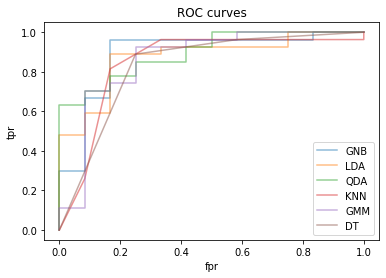

In [101]:
#3
Xtrain,Xtest,ytrain,ytest= train_test_split(X,targets, test_size= .5,random_state=0)

#GNB
clf1 = GaussianNB()
clf1.fit(Xtrain, ytrain)
y_prob1 = clf1.predict_proba(Xtest)[:,1]
fpr1, tpr1, thresh1 = roc_curve(ytest, y_prob1) 
plt.plot(fpr1, tpr1,alpha=0.5,label='GNB')
 
#LDA
clf2 = LinearDiscriminantAnalysis()
clf2.fit(Xtrain, ytrain)
y_prob2 = clf2.predict_proba(Xtest)[:,1]
fpr2, tpr2, thresh2 = roc_curve(ytest, y_prob2) 
plt.plot(fpr2, tpr2,alpha=0.5,label='LDA')

#QDA
clf3 = QuadraticDiscriminantAnalysis()
clf3.fit(Xtrain, ytrain)
y_prob3 = clf3.predict_proba(Xtest)[:,1]
fpr3, tpr3, thresh3 = roc_curve(ytest, y_prob3) 
plt.plot(fpr3, tpr3,alpha=0.5,label='QDA')


#KNN
clf4 = KNeighborsClassifier(10)
clf4.fit(Xtrain, ytrain)
y_prob4 = clf4.predict_proba(Xtest)[:,1]
fpr4, tpr4, thresh4 = roc_curve(ytest, y_prob4) 
plt.plot(fpr4, tpr4,alpha=0.5,label='KNN')

#GMM
clf5 = GMMBayes(2)
clf5.fit(Xtrain, ytrain)
y_prob5 = clf5.predict_proba(Xtest)[:,1]
fpr5, tpr5, thresh5 = roc_curve(ytest, y_prob5) 
plt.plot(fpr5, tpr5,alpha=0.5,label='GMM')

#DT
clf6 = DecisionTreeClassifier(max_depth=2,criterion='entropy')
clf6.fit(Xtrain, ytrain)
y_prob6= clf6.predict_proba(Xtest)[:,1]
fpr6, tpr6, thresh6 = roc_curve(ytest, y_prob6) 
plt.plot(fpr6, tpr6,alpha=0.5,label='DT')
    
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curves')
plt.legend()
plt.show()

total number of test galaxies = 39
correctly identified galaxies = 33


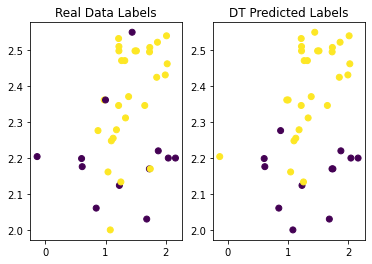

In [131]:
#4
#trying different depths
clf7 = DecisionTreeClassifier(max_depth=1,criterion='entropy')
clf7.fit(Xtrain, ytrain)
y_pred7 = clf7.predict(Xtest)
print('total number of test galaxies = '+str(len(Xtest)))
matches= np.where(ytest==y_pred7)
print('correctly identified galaxies = '+str(len(matches[0])))

#The accuracy for a max depth of 1 is only 1 fewer correct classification than for a max depth of 150
#so seemingly it doesn't get better than this

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(Xtest[:,0],Xtest[:,1],c=ytest)
ax1.set_title('Real Data Labels')
ax2.scatter(Xtest[:,0],Xtest[:,1],c=y_pred7)
ax2.set_title('DT Predicted Labels')

plt.show()

sigma coef = [5.62532304]
sigma intercept = 25.207891414987444
Number being fit = 78


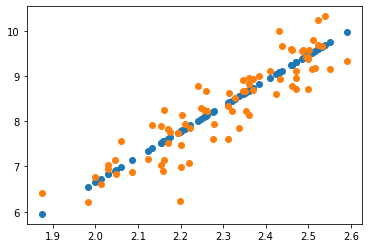

lv coef = [28.56186065]
lv intercept = 293.7030593558462
Number being fit= 48


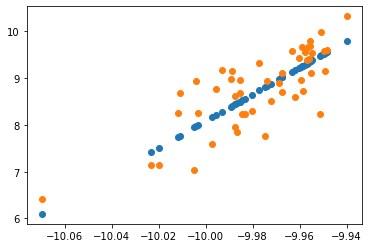

bulge coef = [0.90612685]
bulge intercept = 8.544316160785682
Number being fit= 38


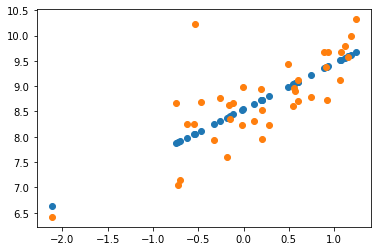

In [173]:
#5
#I consulted stack exchange to see what the new uncertainty should be (https://physics.stackexchange.com/questions/442683/uncertainties-in-logarithms)
unc= (data2['MBH upper (68%)'] - data2['MBH lower (68%)'])/2
unc= unc/data2['MBH (Msun)']
y= X[:,2]

model1 = LinearRegression()
model1.fit(X[:,1].reshape(-1,1)-np.log(200),y,unc)
yfinal1= (X[:,1]-np.log(200))*model1.coef_+ model1.intercept_
plt.scatter(X[:,1],yfinal1)
plt.scatter(X[:,1],y)
print('sigma coef = '+str(model1.coef_))
print('sigma intercept = '+str(model1.intercept_))
print('Number being fit = '+str(78))
plt.show()

ylv= y[data2['log(LV/Lsun)']!=0]
lv= np.asarray(data2['log(LV/Lsun)'])
lv=lv[data2['log(LV/Lsun)']!=0]
lv=np.log10(lv/10**11)
unclv= unc[data2['log(LV/Lsun)']!=0]
model2 = LinearRegression()
model2.fit(lv.reshape(-1,1),ylv,unclv)
yfinal2= lv*model2.coef_+model2.intercept_
plt.scatter(lv,yfinal2)
plt.scatter(lv,ylv)
print('lv coef = '+str(model2.coef_))
print('lv intercept = '+str(model2.intercept_))
print('Number being fit= '+str(len(ylv)))
plt.show()

ybulge= y[data2['Mbulge/Msun']!=0]
bulge= np.asarray(data2['Mbulge/Msun'])
bulge=bulge[data2['Mbulge/Msun']!=0]
bulge= np.log10(bulge/10**11)
uncbulge= unc[data2['Mbulge/Msun']!=0]
model3 = LinearRegression()
model3.fit(bulge.reshape(-1,1),ybulge,uncbulge)
yfinal3= bulge*model3.coef_+model3.intercept_
plt.scatter(bulge,yfinal3)
plt.scatter(bulge,ybulge)
print('bulge coef = '+str(model3.coef_))
print('bulge intercept = '+str(model3.intercept_))
print('Number being fit= '+str(len(ybulge)))
plt.show()

1 degree model coeff = [14.27252736  2.08956514]
2 degree model coeff = [197.62767765 121.45539811  19.3794119 ]
3 degree model coeff = [-785.1869364  -851.6284237  -301.17975491  -35.1382254 ]
4 degree model coeff = [-33288.41846289 -43820.85346287 -21578.80313275  -4712.71519318
   -385.19079369]
5 degree model coeff = [49839.66113564 92714.26994898 68001.63364377 24634.54102785
  4415.58689846   313.71868209]


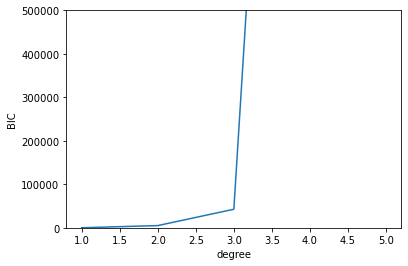

In [190]:
#6
#borrowing the routine from the hw, making changes as necessary 
d= np.arange(1,6)
err = np.empty([5])
for i in range(len(d)):
    modelPRs = PolynomialRegression(d[i]) 
    modelPRs.fit(X[:,1].reshape(-1,1)-np.log(200),y,unc)
    y_predPRs = modelPRs.predict(X[:,1].reshape(-1,1))
    err[i] = np.sqrt(np.sum((y_predPRs - y) ** 2)/ len(y))
    print(str(i+1)+' degree model coeff = '+str(modelPRs.coef_))
BIC = np.sqrt(len(y)) * err / 1 + d * np.log(len(y))
plt.plot(d,BIC)
plt.xlabel('degree')
plt.ylim(0,0.5e6)
plt.ylabel('BIC')
plt.show()

#Nothing more than a quadratic is preferred, but it seems linear and quadratic are ok with linear being best.

early coef = [5.36633596]
early intercept = 24.499612127624616
late coef = [4.65365612]
late intercept = 21.94469640580359


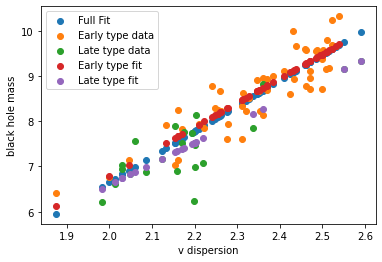

In [201]:
#7
massearly= y[targets!=0]
masslate= y[targets==0]
uncearly= unc[targets!=0]
sigma= X[:,1]
sigmaearly= sigma[targets!=0]
sigmalate= sigma[targets==0]
unclate= unc[targets==0]

modelearly = LinearRegression()
modelearly.fit(sigmaearly.reshape(-1,1)-np.log(200),massearly,uncearly)
yearly= (sigmaearly-np.log(200))*modelearly.coef_+ modelearly.intercept_
plt.scatter(X[:,1],yfinal1,label= 'Full Fit')
plt.scatter(sigmaearly,massearly,label='Early type data')
plt.scatter(sigmalate,masslate,label='Late type data')
plt.scatter(sigmaearly,yearly,label='Early type fit')
print('early coef = '+str(modelearly.coef_))
print('early intercept = '+str(modelearly.intercept_))
plt.xlabel('v dispersion')
plt.ylabel('black hole mass')

modellate = LinearRegression()
modellate.fit(sigmalate.reshape(-1,1)-np.log(200),masslate,unclate)
ylate= (sigmalate-np.log(200))*modellate.coef_+ modellate.intercept_
plt.scatter(sigmalate,ylate,label='Late type fit')
print('late coef = '+str(modellate.coef_))
print('late intercept = '+str(modellate.intercept_))
plt.ylabel('black hole mass')
plt.legend()
plt.show()


In [ ]:
#fitting late type galaxies only implies smaller bh masses and v dispersions, probably bc these galaxies themselves 
#are smaller and rotationally supported